## Here we will be loading the wind experiment and then recalculate correlatins
## EASTERLIES

### Good example to follow
#### - https://github.com/adele157/easterlies-collaborative-project/blob/master/notebooks/example_notebook.ipynb

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import gsw
import dask.distributed as dsk
from mpl_toolkits.axes_grid1 import make_axes_locatable
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/jk72/ns3783'



In [2]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44741,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:41677,Total threads: 4
Dashboard: /proxy/33739/status,Memory: 18.00 GiB
Nanny: tcp://127.0.0.1:39843,


In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

experiment_eup = '01deg_jra55v13_ryf9091_easterlies_up10'
#experiment_edo = '01deg_jra55v13_ryf9091_easterlies_down10'
easterlies_up_zonal = '01deg_jra55v13_ryf9091_easterlies_up10_zonal'
#easterlies_up_meridional = '01deg_jra55v13_ryf9091_easterlies_up10_meridional'
#easterlies_up_noDSW = '01deg_jra55v13_ryf9091_easterlies_up10_noDSW'


# plot anomalies for last 5 years of simulation:
start_time='2150-01-01'   #try with 2150 again?
end_time='2159-12-31'


### PREPARE TEMPERATURE

In [4]:
depth_slice = slice(400, 6000)
#lat_slice  = slice(-79,-59)
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-275, -230)

temp_con = cc.querying.getvar(control,'temp', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)                             
temp_con = temp_con.load()

# a bit of a change here, getting the experiment where both are up 
# temp_up = cc.querying.getvar(easterlies_up_meridional,'temp',master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
# temp_upY = temp_up.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)                      
# temp_upY = temp_upY.load()

temp_up = cc.querying.getvar(experiment_eup,'temp',master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_upY = temp_up.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)                      
temp_upY = temp_upY.load()

temp_up = cc.querying.getvar(easterlies_up_zonal,'temp', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_upX = temp_up.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)                           
temp_upX = temp_upX.load()

2024-08-09 10:21:04,183 - distributed.worker - WARNING - Compute Failed
Key:       open_dataset-6fb081f1-ff31-495e-a12b-b5d916c14d54
Function:  execute_task
args:      ((<function apply at 0x14c556e880d0>, <function open_dataset at 0x14c53bb20d30>, ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_easterlies_up10/output1032/ocean/ocean.nc'], (<class 'dict'>, [['engine', None], ['chunks', (<class 'dict'>, [['time', 1], ['st_ocean', 19], ['yt_ocean', 135], ['xt_ocean', 180]])]])))
kwargs:    {}
Exception: "FileNotFoundError(2, 'No such file or directory')"

2024-08-09 10:21:04,187 - distributed.worker - WARNING - Compute Failed
Key:       open_dataset-6d585167-fc78-4653-9763-c85f0cd44293
Function:  execute_task
args:      ((<function apply at 0x14b0227ef0d0>, <function open_dataset at 0x14b007458700>, ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_easterlies_up10/output1013/ocean/ocean.nc'], (<class 'dict'>, [['engine', None], ['chunks', (<class 'dict'>, [['time', 

FileNotFoundError: [Errno 2] No such file or directory: b'/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_easterlies_up10/output1032/ocean/ocean.nc'

In [ ]:
# depth average:
# there is no dzu saved
# calculate grid thickness, adjusted for partial cells:
zlevel1 = 400
zlevel2 = 6000

# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(control,'st_edges_ocean',master_session,
                 start_time=start_time, end_time=end_time,n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':temp_con.yt_ocean,'xt_ocean':temp_con.xt_ocean},axis=[1,2])
# import bathymetry:
ht = cc.querying.getvar(control,'ht',master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht,other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(control,'st_ocean',master_session,n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

# select correct depths:
thickness = thickness.sel(st_ocean=slice(zlevel1,zlevel2))

# multiply by thickness to avg
temp_con = (temp_con*thickness).sum('st_ocean')/thickness.sum('st_ocean')
temp_upX = (temp_upX*thickness).sum('st_ocean')/thickness.sum('st_ocean')
temp_upY = (temp_upY*thickness).sum('st_ocean')/thickness.sum('st_ocean')

In [ ]:
##test if temp is still working after the depth weighting
temp_upY[0,...].plot()
#temp_upY.plot()

In [ ]:
temp_con = temp_con.mean('time')
temp_upX = temp_upX.mean('time')
temp_upY = temp_upY.mean('time')

In [ ]:
temp_con = temp_con.load()
temp_upX = temp_upX.load()
temp_upY = temp_upY.load()

### LOAD ISOPYCNALS 

In [ ]:
# load temperature data at 200m (defined on transect):
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-256, -246)

temp_iso = cc.querying.getvar(control,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_iso = temp_iso.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
temp_iso = temp_iso.load()

temp_iso_upX = cc.querying.getvar(easterlies_up_zonal,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_iso_upX = temp_iso_upX.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
temp_iso_upX = temp_iso_upX.load()

# temp_iso_upY = cc.querying.getvar(easterlies_up_meridional,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
# temp_iso_upY = temp_iso_upY.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# temp_iso_upY = temp_iso_upY.load()

temp_iso_upY = cc.querying.getvar(experiment_edo,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_iso_upY = temp_iso_upY.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
temp_iso_upY = temp_iso_upY.load()

sal_iso = cc.querying.getvar(control,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
sal_iso = sal_iso.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
sal_iso = sal_iso.load()

sal_iso_upX = cc.querying.getvar(easterlies_up_zonal,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
sal_iso_upX = sal_iso_upX.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
sal_iso_upX = sal_iso_upX.load()

# sal_iso_upY = cc.querying.getvar(easterlies_up_meridional,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
# sal_iso_upY = sal_iso_upY.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# sal_iso_upY = sal_iso_upY.load()

sal_iso_upY = cc.querying.getvar(experiment_edo,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
sal_iso_upY = sal_iso_upY.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
sal_iso_upY = sal_iso_upY.load()

In [ ]:
# calculate density along transect:
# arrays for gsw to use
depth_array = temp_iso*0 + temp_iso.st_ocean
lat_array = temp_iso*0 + temp_iso.yt_ocean
# need to convert practical salinity to absolute salinity:
pressure = gsw.p_from_z(-depth_array,lat_array)
# need to convert practical salinity to absolute salinity:
salt_abs = gsw.SA_from_SP(sal_iso,pressure,sal_iso.xt_ocean,lat_array)
#calculate sigma
sigma0 = gsw.sigma0(salt_abs,temp_iso)

# calculate density along transect:
# arrays for gsw to use
depth_array_upX = temp_iso_upX*0 + temp_iso_upX.st_ocean
lat_array_upX = temp_iso_upX*0 + temp_iso_upX.yt_ocean
# need to convert practical salinity to absolute salinity:
pressure_upX = gsw.p_from_z(-depth_array_upX,lat_array_upX)
# need to convert practical salinity to absolute salinity:
salt_abs_upX = gsw.SA_from_SP(sal_iso_upX,pressure_upX,sal_iso_upX.xt_ocean,lat_array_upX)
#calculate sigma
sigma0_upX = gsw.sigma0(salt_abs_upX,temp_iso_upX)


# calculate density along transect:
# arrays for gsw to use
depth_array_upY = temp_iso_upY*0 + temp_iso_upY.st_ocean
lat_array_upY = temp_iso_upY*0 + temp_iso_upY.yt_ocean
# need to convert practical salinity to absolute salinity:
pressure_upY = gsw.p_from_z(-depth_array_upY,lat_array_upY)
# need to convert practical salinity to absolute salinity:
salt_abs_upY = gsw.SA_from_SP(sal_iso_upY,pressure_upY,sal_iso_upY.xt_ocean,lat_array_upY)
#calculate sigma
sigma0_upY = gsw.sigma0(salt_abs_upY,temp_iso_upY)


## We need to mask the shelf out 

In [ ]:
# cut the data BOX 1
lon_slice  = slice(-255, -246)
lat_slice  = slice(-67.5, -63)

# topography data:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

fontsize=16

In [ ]:
# Mask 

# set to 1 everywhere:
region_mask = ht*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_700m.npz')
#contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_1000m.npz')
shelf_mask = contour_file['temp_mask']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1

shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

region_mask = region_mask * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)


plt.figure(figsize=(8,6))
region_mask.plot()
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[1000,2000,3000],colors='k')
#plt.xlim(-275,-245)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

In [ ]:
#apply the mask
sigma0 = sigma0*region_mask
sigma0 = sigma0.where(sigma0!=0)

#apply the mask
sigma0_upX = sigma0_upX*region_mask
sigma0_upX = sigma0_upX.where(sigma0_upX!=0)

#apply the mask
sigma0_upY = sigma0_upY*region_mask
sigma0_upY = sigma0_upY.where(sigma0_upY!=0)

In [ ]:
# first time step only:
sigma0[0,0,...].plot()

In [ ]:
rho_thresh = 27.82

# mask density where < rho_thresh:
sigma0_off_mask = sigma0.where(sigma0>rho_thresh)
# check this worked:
#sigma0_off_mask[0,:,:,0].plot()

# Now find first depth where sigma0_off_mask is not masked:
depth_array = sigma0*0 + sigma0.st_ocean
# mask depth array using density threshold:
depth_array_masked = depth_array.where(sigma0>rho_thresh)
# find minimum depth at each lat,lon location:
min_depth = depth_array_masked.min(dim='st_ocean')

#rename the isopycnal
iso2782_dth=min_depth



# mask density where < rho_thresh:
sigma0_off_mask_upX = sigma0_upX.where(sigma0_upX>rho_thresh)
# check this worked:
#sigma0_off_mask[0,:,:,0].plot()

# Now find first depth where sigma0_off_mask is not masked:
depth_array_upX = sigma0_upX*0 + sigma0_upX.st_ocean
# mask depth array using density threshold:
depth_array_masked_upX = depth_array_upX.where(sigma0_upX>rho_thresh)
# find minimum depth at each lat,lon location:
min_depth_upX = depth_array_masked_upX.min(dim='st_ocean')

#rename the isopycnal
iso2782_dth_upX=min_depth_upX


# mask density where < rho_thresh:
sigma0_off_mask_upY = sigma0_upY.where(sigma0_upY>rho_thresh)
# check this worked:
#sigma0_off_mask[0,:,:,0].plot()

# Now find first depth where sigma0_off_mask is not masked:
depth_array_upY = sigma0_upY*0 + sigma0_upY.st_ocean
# mask depth array using density threshold:
depth_array_masked_upY = depth_array_upY.where(sigma0_upY>rho_thresh)
# find minimum depth at each lat,lon location:
min_depth_upY = depth_array_masked_upY.min(dim='st_ocean')

#rename the isopycnal
iso2782_dth_upY=min_depth_upY

In [ ]:
isocon = iso2782_dth.mean('time')
iso_upX = iso2782_dth_upX.mean('time')
iso_upY = iso2782_dth_upY.mean('time')

In [ ]:
isocon = isocon.load()
isocon_upX = iso_upX.load()
isocon_upY = iso_upY.load()

In [ ]:
#isocon 

### LOAD BATHYMETRY

In [ ]:
#have to load this again
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-275, -246)

# import bathymetry and the land/ocean mask to add to plot:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# create land mask from the bathymetry:
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)]=1
land_mask = np.where(land_mask==1,land_mask,np.nan)

### PLOT COMPOSITES TOGETHER 

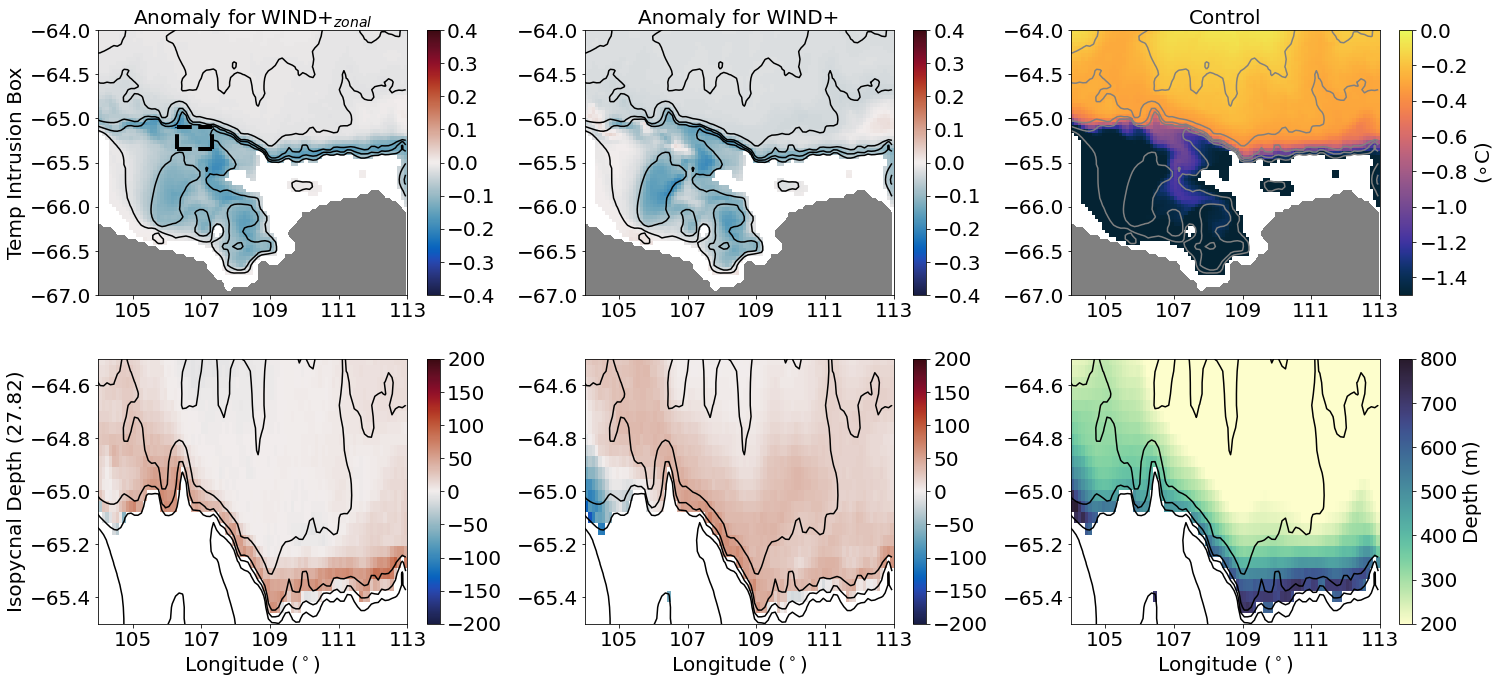

In [70]:
fontsize=20


#for nt in range(0,nframes):
fig=plt.figure(figsize=(21, 18))
fig.subplots_adjust(top=0.88)

t_high = temp_upX-temp_con;
t_low = temp_upY-temp_con;
ax0=plt.subplot(431) 
pc = plt.pcolormesh(t_high.xt_ocean,t_high.yt_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-0.4,vmax=0.4)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('Anomaly for WIND+$_{zonal}$',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='k',linestyle='--',linewidth=4)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='k',linestyle='--',linewidth=4)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='k',linestyle='--',linewidth=4)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='k',linestyle='--',linewidth=4)
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Temp Intrusion Box',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])

ax0=plt.subplot(4,3,2)      
pc = plt.pcolormesh(t_low.xt_ocean,t_low.yt_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-0.4,vmax=0.4)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for WIND+$_{merid}$',fontsize=fontsize)
plt.title('Anomaly for WIND+',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])

ax0=plt.subplot(4,3,3)    
pc = plt.pcolormesh(temp_con.xt_ocean,temp_con.yt_ocean,
                        temp_con, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=0)
plt.title('Control',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='gray',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'($\circ$C)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])


t_high = isocon_upX-isocon;
t_low = isocon_upY-isocon;
ax0=plt.subplot(434) 
pc = plt.pcolormesh(t_high.xt_ocean,t_high.yt_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-200,vmax=200)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for rising Temp yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Isopycnal Depth (27.82)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-65.5, -64.5))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'Depth (m)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,5)      
pc = plt.pcolormesh(t_low.xt_ocean,t_low.yt_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-200,vmax=200)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for Lowering T yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-65.5, -64.5))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'Depth (m)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,6)    
pc = plt.pcolormesh(isocon.xt_ocean,isocon.yt_ocean,
                        isocon, cmap = cmocean.deep, 
                        vmin=200,vmax=800)
#plt.title('Avg for all yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-65.5, -64.5))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)

cbar.set_label(r'Depth (m)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)


#fig.tight_layout()
#figdir = '/home/581/ns3783/Scripts/Figures/Current'
#filestr = figdir+'/fig8b_easterlies_composite_wind+.png'
#plt.savefig(filestr,dpi=600,bbox_inches='tight')

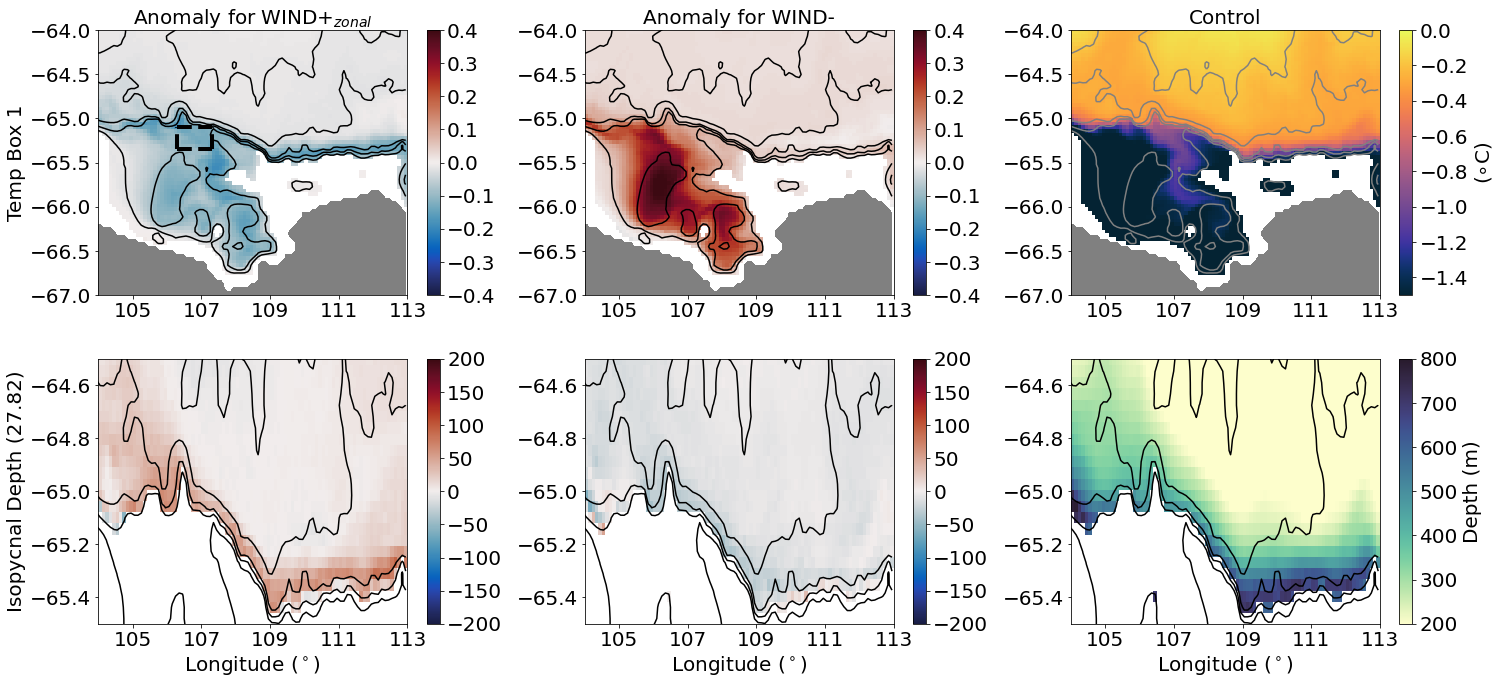

In [20]:
## doing with wind down just for records
fontsize=20


#for nt in range(0,nframes):
fig=plt.figure(figsize=(21, 18))
fig.subplots_adjust(top=0.88)

t_high = temp_upX-temp_con;
t_low = temp_upY-temp_con;
ax0=plt.subplot(431) 
pc = plt.pcolormesh(t_high.xt_ocean,t_high.yt_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-0.4,vmax=0.4)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('Anomaly for WIND+$_{zonal}$',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='k',linestyle='--',linewidth=4)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='k',linestyle='--',linewidth=4)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='k',linestyle='--',linewidth=4)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='k',linestyle='--',linewidth=4)
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Temp Box 1',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])

ax0=plt.subplot(4,3,2)      
pc = plt.pcolormesh(t_low.xt_ocean,t_low.yt_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-0.4,vmax=0.4)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for WIND+$_{merid}$',fontsize=fontsize)
plt.title('Anomaly for WIND-',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'($\circ$C)', fontsize = 16,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])

ax0=plt.subplot(4,3,3)    
pc = plt.pcolormesh(temp_con.xt_ocean,temp_con.yt_ocean,
                        temp_con, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=0)
plt.title('Control',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='gray',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'($\circ$C)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])


t_high = isocon_upX-isocon;
t_low = isocon_upY-isocon;
ax0=plt.subplot(434) 
pc = plt.pcolormesh(t_high.xt_ocean,t_high.yt_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-200,vmax=200)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for rising Temp yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Isopycnal Depth (27.82)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-65.5, -64.5))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'Depth (m)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,5)      
pc = plt.pcolormesh(t_low.xt_ocean,t_low.yt_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-200,vmax=200)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
#plt.title('Anomaly for Lowering T yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-65.5, -64.5))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
#cbar.set_label(r'Depth (m)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,6)    
pc = plt.pcolormesh(isocon.xt_ocean,isocon.yt_ocean,
                        isocon, cmap = cmocean.deep, 
                        vmin=200,vmax=800)
#plt.title('Avg for all yrs',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-65.5, -64.5))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)

cbar.set_label(r'Depth (m)', fontsize = 20,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)


fig.tight_layout()
figdir = '/home/581/ns3783/Scripts/Figures/Current'
filestr = figdir+'/fig8b_easterlies_composite_wind-.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')
